In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os, shutil
import cv2
import matplotlib.image as mpimg
import seaborn as sns
%matplotlib inline
plt.style.use('ggplot')

In [2]:
# Dataset
import zipfile

z = zipfile.ZipFile('archive.zip')

z.extractall()

In [3]:
folder = 'brain_tumor_dataset/yes/'
count = 1

for filename in os.listdir(folder):
    source = folder + filename
    destination = folder + "Y_" +str(count)+".jpg"
    os.rename(source, destination)
    count+=1
print("All files are renamed in the yes dir.")

All files are renamed in the yes dir.


In [4]:
folder = 'brain_tumor_dataset/no/'
count = 1

for filename in os.listdir(folder):
    source = folder + filename
    destination = folder + "N_" +str(count)+".jpg"
    os.rename(source, destination)
    count+=1
print("All files are renamed in the no dir.")

All files are renamed in the no dir.


In [ ]:
# EDA(Exploratory Data Analysis)

In [5]:
listyes = os.listdir("brain_tumor_dataset/yes/")
number_files_yes = len(listyes)
print(number_files_yes)

listno = os.listdir("brain_tumor_dataset/no/")
number_files_no = len(listno)
print(number_files_no)

155
98


In [ ]:
# Plot

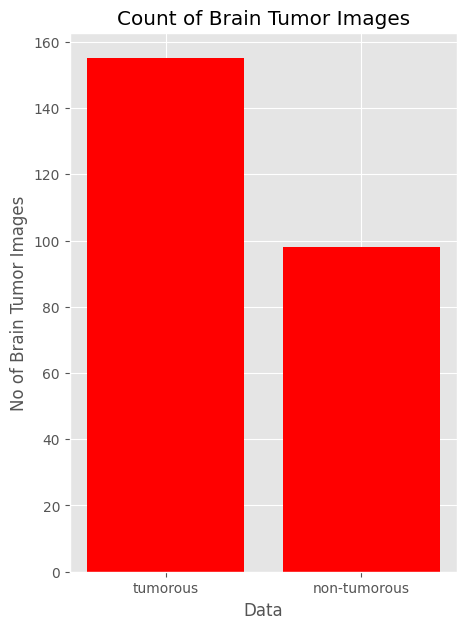

In [6]:
data = {'tumorous': number_files_yes, 'non-tumorous': number_files_no}

typex = data.keys()
values = data.values()

fig = plt.figure(figsize=(5,7))

plt.bar(typex, values, color="red")

plt.xlabel("Data")
plt.ylabel("No of Brain Tumor Images")
plt.title("Count of Brain Tumor Images")
plt.show()

In [7]:
# Data Augmentation
# 155(61%), 98(39%)
# imbalance

In [8]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

In [9]:
def timing(sec_elapsed):
    h = int(sec_elapsed / (60*60))
    m = int(sec_elapsed % (60*60) / 60)
    s = sec_elapsed % 60
    return f"{h}:{m}:{s}"

In [10]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
import os

def augmented_data(file_dir, n_generated_samples, save_to_dir):
    datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest'
    )

    if not os.path.exists(save_to_dir):
        os.makedirs(save_to_dir)

    for img_file in os.listdir(file_dir):
        img_path = os.path.join(file_dir, img_file)
        img = load_img(img_path)  # Load image
        img = img.resize((240, 240))  # Resize image if needed
        x = img_to_array(img)  # Convert to numpy array
        x = x.reshape((1,) + x.shape)  # Reshape

        i = 0
        for batch in datagen.flow(x, batch_size=1, save_to_dir=save_to_dir, save_prefix='aug', save_format='jpeg'):
            i += 1
            if i >= n_generated_samples:
                break


In [11]:
import time
start_time = time.time()

yes_path = 'brain_tumor_dataset/yes'
no_path = 'brain_tumor_dataset/no'
augmented_data_path = "augmented_data/"

# Example usage; adjust n_generated_samples based on your specific balance goals
augmented_data(file_dir=yes_path, n_generated_samples=7, save_to_dir=augmented_data_path + 'yes')  # For "yes" class
augmented_data(file_dir=no_path, n_generated_samples=10, save_to_dir=augmented_data_path + 'no')  # For "no" class

end_time = time.time()
execution_time = end_time - start_time
print(f"Execution time: {execution_time} seconds")


Execution time: 26.228461265563965 seconds


In [12]:
def data_summary(main_path):
    yes_path = os.path.join(main_path, "yes/")
    no_path = os.path.join(main_path, "no/")

    n_pos = len(os.listdir(yes_path))
    n_neg = len(os.listdir(no_path))

    n = (n_pos + n_neg)

    pos_per = (n_pos * 100) / n
    neg_per = (n_neg * 100) / n

    print(f"Number of sample: {n}")
    print(f"{n_pos} Number of positive sample in percentage: {pos_per}%")
    print(f"{n_neg} Number of negative sample in percentage: {neg_per}%")

data_summary(augmented_data_path)


Number of sample: 1948
1019 Number of positive sample in percentage: 52.31006160164271%
929 Number of negative sample in percentage: 47.68993839835729%


In [13]:
listyes = os.listdir("augmented_data/yes/")
number_files_yes = len(listyes)
print(number_files_yes)

listno = os.listdir("augmented_data/no/")
number_files_no = len(listno)
print(number_files_no)

1019
929


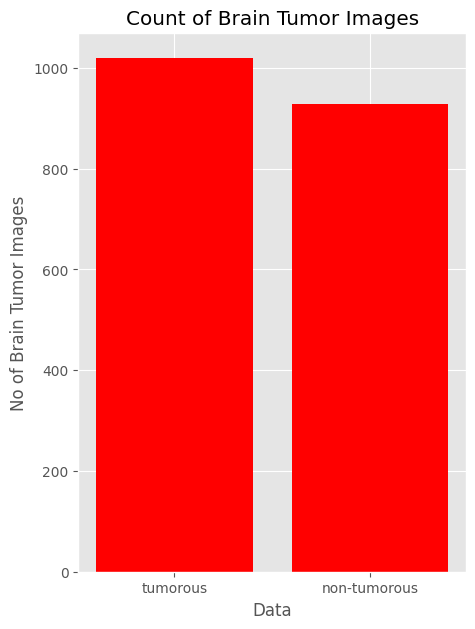

In [14]:
data = {'tumorous': number_files_yes, 'non-tumorous': number_files_no}

typex = data.keys()
values = data.values()

fig = plt.figure(figsize=(5,7))

plt.bar(typex, values, color="red")

plt.xlabel("Data")
plt.ylabel("No of Brain Tumor Images")
plt.title("Count of Brain Tumor Images")
plt.show()

In [ ]:
# Data Preprocessing

In [ ]:
# Convert BGR TO GRAY
# GaussianBlur
# Threshold
# Erode
# Dilate
# Find Contours

In [15]:
import imutils
def crop_brain_tumor(image, plot=False):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    gray = cv2.GaussianBlur(gray, (5,5), 0)

    thres = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]
    thres =cv2.erode(thres, None, iterations = 2)
    thres = cv2.dilate(thres, None, iterations = 2)

    cnts = cv2.findContours(thres.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)
    c = max(cnts, key = cv2.contourArea)

    extLeft = tuple(c[c[:,:,0].argmin()][0])
    extRight = tuple(c[c[:,:,0].argmax()][0])
    extTop = tuple(c[c[:,:,1].argmin()][0])
    extBot = tuple(c[c[:,:,1].argmax()][0])

    new_image = image[extTop[1]:extBot[1], extLeft[0]:extRight[0]]

    if plot:
        plt.figure()
        plt.subplot(1, 2, 1)
        plt.imshow(image)

        plt.tick_params(axis='both', which='both',
                        top=False, bottom=False, left=False, right=False,
                        labelbottom=False, labeltop=False, labelleft=False, labelright=False)

        plt.title('Original Image')

        plt.subplot(1, 2, 2)
        plt.imshow(new_image)

        plt.tick_params(axis='both', which='both',
                        top=False, bottom=False, left=False, right=False,
                        labelbottom=False, labeltop=False, labelleft=False, labelright=False)

        plt.title('Cropped Image')
        plt.show()
    return new_image


In [ ]:
img = cv2.imread('augmented_data/yes/aug_0_1.jpeg')
crop_brain_tumor(img, True)

error: OpenCV(4.8.0) /io/opencv/modules/imgproc/src/color.cpp:182: error: (-215:Assertion failed) !_src.empty() in function 'cvtColor'


In [ ]:
img = cv2.imread('augmented_data/no/aug_N_1_0_109.jpg')
crop_brain_tumor(img, True)

In [16]:
folder1 = 'augmented_data/no/'
folder2 = 'augmented_data/yes/'

for filename in os.listdir(folder1):
    img = cv2.imread(folder1 + filename)
    img = crop_brain_tumor(img, False)
    cv2.imwrite(folder1 + filename, img)
for filename in os.listdir(folder2):
    img = cv2.imread(folder2 + filename)
    img = crop_brain_tumor(img, False)
    cv2.imwrite(folder2 + filename, img)

In [ ]:
# image loading

In [17]:
from sklearn.utils import shuffle
def load_data(dir_list, image_size):
    X=[]
    y=[]

    image_width, image_height=image_size

    for directory in dir_list:
        for filename in os.listdir(directory):
            image = cv2.imread(directory + '/' + filename)
            image = crop_brain_tumor(image, plot=False)
            image = cv2.resize(image, dsize=(image_width, image_height), interpolation = cv2.INTER_CUBIC)
            image = image/255.00
            X.append(image)
            if directory[-3:] == "yes":
                y.append(1)
            else:
                y.append(0)
    X=np.array(X)
    y=np.array(y)

    X,y = shuffle(X,y)
    print(f"Number of example is : {len(X)}")
    print(f"X SHAPE is : {X.shape}")
    print(f"y SHAPE is : {y.shape}")
    return X,y


In [18]:
augmented_path = 'augmented_data/'
augmeneted_yes = augmented_path + 'yes'
augmeneted_no = augmented_path + 'no'

IMAGE_WIDTH, IMAGE_HEIGHT = (240,240)

X,y = load_data([augmeneted_yes, augmeneted_no], (IMAGE_WIDTH, IMAGE_HEIGHT))

Number of example is : 1948
X SHAPE is : (1948, 240, 240, 3)
y SHAPE is : (1948,)


In [19]:
def plot_sample_images(X, y, n=50):

    for label in [0,1]:
        images = X[np.argwhere(y == label)]
        n_images = images[:n]

        columns_n = 10
        rows_n = int(n/ columns_n)

        plt.figure(figsize=(20, 10))

        i = 1
        for image in n_images:
            plt.subplot(rows_n, columns_n, i)
            plt.imshow(image[0])

            plt.tick_params(axis='both', which='both',
                            top=False, bottom=False, left=False, right=False,
                            labelbottom=False, labeltop=False, labelleft=False,
                            labelright=False)

            i += 1

        label_to_str = lambda label: "Yes" if label == 1 else "No"
        plt.suptitle(f"Brain Tumor: {label_to_str(label)}")
        plt.show()

In [ ]:
plot_sample_images(X,y)

In [ ]:
# Data Spliting
# Train
# Test
# Validation

In [39]:
import os
import shutil
from sklearn.model_selection import train_test_split

# Define the paths
base_dir = "augmented_data"
categories = ["yes", "no"]

train_dir = os.path.join(base_dir, "train")
test_dir = os.path.join(base_dir, "test")
valid_dir = os.path.join(base_dir, "validation")

# Make sure the directories exist
for dir in [train_dir, test_dir, valid_dir]:
    for category in categories:
        os.makedirs(os.path.join(dir, category), exist_ok=True)

def split_data(category):
    files = os.listdir(os.path.join(base_dir, category))
    train_files, test_files = train_test_split(files, test_size=0.2, random_state=42)
    test_files, valid_files = train_test_split(test_files, test_size=0.5, random_state=42)

    # Copy files to their respective directories
    for file in train_files:
        shutil.copyfile(os.path.join(base_dir, category, file),
                        os.path.join(train_dir, category, file))

    for file in test_files:
        shutil.copyfile(os.path.join(base_dir, category, file),
                        os.path.join(test_dir, category, file))

    for file in valid_files:
        shutil.copyfile(os.path.join(base_dir, category, file),
                        os.path.join(valid_dir, category, file))

# Apply the function to both categories
for category in categories:
    split_data(category)


use ImageDataGenerator class is a convenient tool for loading and augmenting image data directly from directories.

In [54]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_dir = 'augmented_data/train'
validation_dir = 'augmented_data/validation'
test_dir = 'augmented_data/test'

# Rescale pixel values from [0, 255] to [0, 1]
train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

# Automatically fetch images from the directories, assuming binary classification
train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=(150, 150),  # Resize images
        batch_size=20,
        class_mode='binary')  # because you use binary_crossentropy loss

validation_generator = test_datagen.flow_from_directory(
        validation_dir,
        target_size=(150, 150),
        batch_size=20,
        class_mode='binary')



Found 1558 images belonging to 2 classes.
Found 195 images belonging to 2 classes.


build the model

In [58]:
from tensorflow.keras import layers
from tensorflow.keras import models

model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dropout(0.5))  # Dropout for regularization
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))  # Sigmoid for binary classification

model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])


model.summary()


Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_13 (Conv2D)          (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d_13 (MaxPooli  (None, 74, 74, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_14 (Conv2D)          (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_14 (MaxPooli  (None, 36, 36, 64)        0         
 ng2D)                                                           
                                                                 
 conv2d_15 (Conv2D)          (None, 34, 34, 128)       73856     
                                                                 
 max_pooling2d_15 (MaxPooli  (None, 17, 17, 128)      

Implement ModelCheckpoint and EarlyStopping Callbacks

In [62]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# EarlyStopping to halt training when validation loss stops improving
early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1)

# ModelCheckpoint to save the best model based on validation accuracy

model_checkpoint = ModelCheckpoint(filepath='best_model.h5', monitor='val_accuracy', save_best_only=True, verbose=1)
callbacks = [early_stopping, model_checkpoint]


Train Your Model
Now, you can train the model using the data provided by the train_generator and validate it using the validation_generator.

In [63]:
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,  # Correctly calculates steps per epoch
    epochs=100,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // validation_generator.batch_size,  # Correctly calculates validation steps
    callbacks=[early_stopping, model_checkpoint],  # Includes both callbacks
    verbose=1)



Epoch 1/100
76/77 [============================>.] - ETA: 0s - loss: 0.0661 - accuracy: 0.9796
Epoch 1: val_accuracy improved from -inf to 0.83889, saving model to best_model.h5
77/77 [==============================] - 2s 28ms/step - loss: 0.0654 - accuracy: 0.9798 - val_loss: 0.4726 - val_accuracy: 0.8389
Epoch 2/100
76/77 [============================>.] - ETA: 0s - loss: 0.0405 - accuracy: 0.9848
Epoch 2: val_accuracy improved from 0.83889 to 0.85000, saving model to best_model.h5
77/77 [==============================] - 2s 28ms/step - loss: 0.0416 - accuracy: 0.9844 - val_loss: 0.3979 - val_accuracy: 0.8500
Epoch 3/100
76/77 [============================>.] - ETA: 0s - loss: 0.0574 - accuracy: 0.9822
Epoch 3: val_accuracy did not improve from 0.85000
77/77 [==============================] - 2s 25ms/step - loss: 0.0567 - accuracy: 0.9824 - val_loss: 0.5255 - val_accuracy: 0.8500
Epoch 4/100
76/77 [============================>.] - ETA: 0s - loss: 0.0481 - accuracy: 0.9855
Epoch 4: v

Step 5: Evaluate the Model

In [64]:
test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=(150, 150),
        batch_size=20,
        class_mode='binary')

# Calculate the correct number of steps to evaluate all test data
# This ensures all images are used once during evaluation
total_test_images = 195  # Total number of images in your test set
batch_size = 20
steps = total_test_images // batch_size

if total_test_images % batch_size > 0:
    steps += 1  # Add an extra step if there are leftover images

test_loss, test_acc = model.evaluate(test_generator, steps=steps)
print('test acc:', test_acc)


Found 195 images belonging to 2 classes.
10/10 [==============================] - 0s 20ms/step - loss: 0.4677 - accuracy: 0.8769
test acc: 0.8769230842590332


#plot the Model loss and accurracy

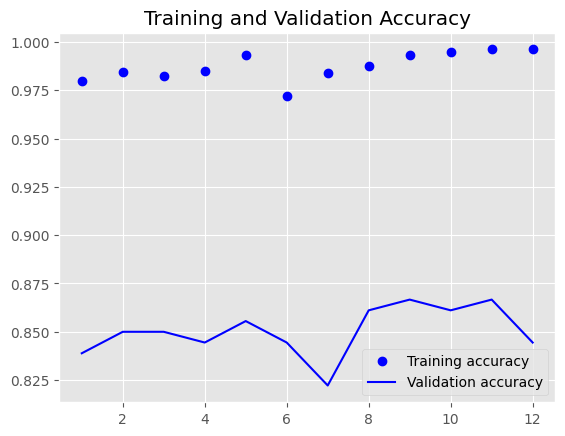

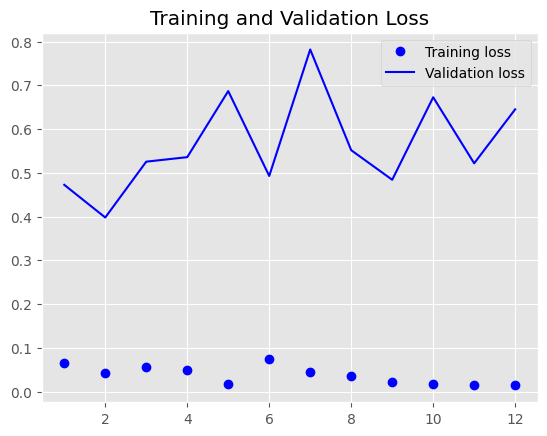

In [65]:
import matplotlib.pyplot as plt

# Assuming 'history' is the result of the 'fit' operation on your model
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

# Plot training and validation accuracy
plt.plot(epochs, acc, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.figure()

# Plot training and validation loss
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.show()


adjust the model's architecture by adding dropout, apply more aggressive data augmentation, and potentially use weight regularization.

In [67]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.regularizers import l2
import math

# Calculate the steps per epoch and validation steps
steps_per_epoch = math.ceil(1558 / batch_size)
validation_steps = math.ceil(195 / batch_size)
# More aggressive data augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Use the same generator for validation, but without augmentation
# Only rescaling should be done for the validation data
validation_datagen = ImageDataGenerator(rescale=1./255)

# Define the model with dropout and L2 regularization
model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2(0.001)),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.3),  # Dropout after pooling

    layers.Conv2D(128, (3, 3), activation='relu', kernel_regularizer=l2(0.001)),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(128, (3, 3), activation='relu', kernel_regularizer=l2(0.001)),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.4),  # Increasing dropout for deeper layers

    layers.Flatten(),
    layers.Dense(512, activation='relu', kernel_regularizer=l2(0.001)),
    layers.Dropout(0.5),  # Dropout in the dense layer
    layers.Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Early stopping and model checkpoint callbacks
callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, verbose=1),
    ModelCheckpoint(filepath='best_model_with_regularization.h5',
                    monitor='val_accuracy',
                    save_best_only=True,
                    verbose=1)
]

# Train the model with the new data augmentation and regularization strategies
history = model.fit(
    train_datagen.flow_from_directory(
        train_dir,
        target_size=(150, 150),
        batch_size=batch_size,
        class_mode='binary'),
    steps_per_epoch=steps_per_epoch,  # Corrected steps per epoch
    epochs=100,
    validation_data=validation_datagen.flow_from_directory(
        validation_dir,
        target_size=(150, 150),
        batch_size=batch_size,
        class_mode='binary'),
    validation_steps=validation_steps,  # Corrected validation steps
    callbacks=callbacks
)


Found 1558 images belonging to 2 classes.
Found 195 images belonging to 2 classes.
Epoch 1/100
78/78 [==============================] - ETA: 0s - loss: 1.1914 - accuracy: 0.5019
Epoch 1: val_accuracy improved from -inf to 0.52308, saving model to best_model_with_regularization.h5
78/78 [==============================] - 12s 119ms/step - loss: 1.1914 - accuracy: 0.5019 - val_loss: 0.8963 - val_accuracy: 0.5231
Epoch 2/100
78/78 [==============================] - ETA: 0s - loss: 0.8236 - accuracy: 0.5276
Epoch 2: val_accuracy did not improve from 0.52308
78/78 [==============================] - 9s 116ms/step - loss: 0.8236 - accuracy: 0.5276 - val_loss: 0.7729 - val_accuracy: 0.5231
Epoch 3/100
78/78 [==============================] - ETA: 0s - loss: 0.7519 - accuracy: 0.5334
Epoch 3: val_accuracy did not improve from 0.52308
78/78 [==============================] - 9s 116ms/step - loss: 0.7519 - accuracy: 0.5334 - val_loss: 0.7350 - val_accuracy: 0.5231
Epoch 4/100
78/78 [==============

evaluate the enhanced model after regularization

In [68]:
# Evaluate the model on the validation set
val_loss, val_accuracy = model.evaluate(validation_datagen.flow_from_directory(
        validation_dir,
        target_size=(150, 150),
        batch_size=batch_size,
        class_mode='binary'),
        steps=validation_steps)

print(f'Validation loss: {val_loss}')
print(f'Validation accuracy: {val_accuracy}')


Found 195 images belonging to 2 classes.
10/10 [==============================] - 0s 22ms/step - loss: 0.6146 - accuracy: 0.6769
Validation loss: 0.6145713329315186
Validation accuracy: 0.6769230961799622


plot the history of enhanced model

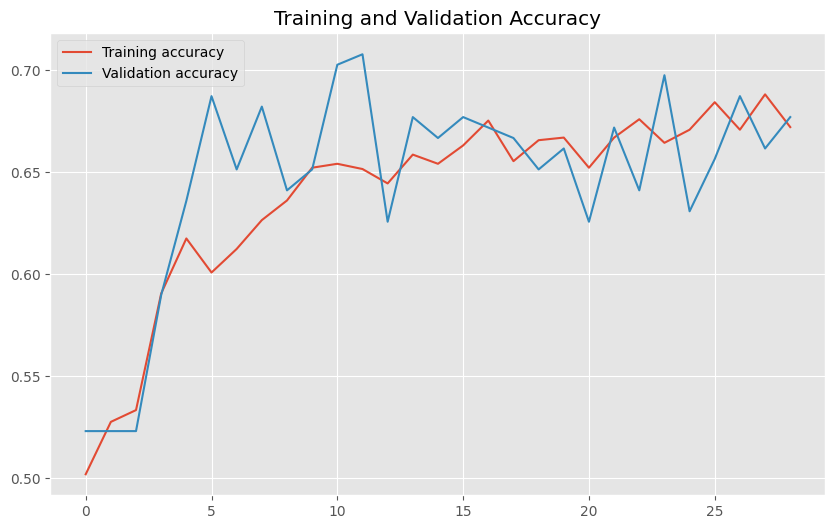

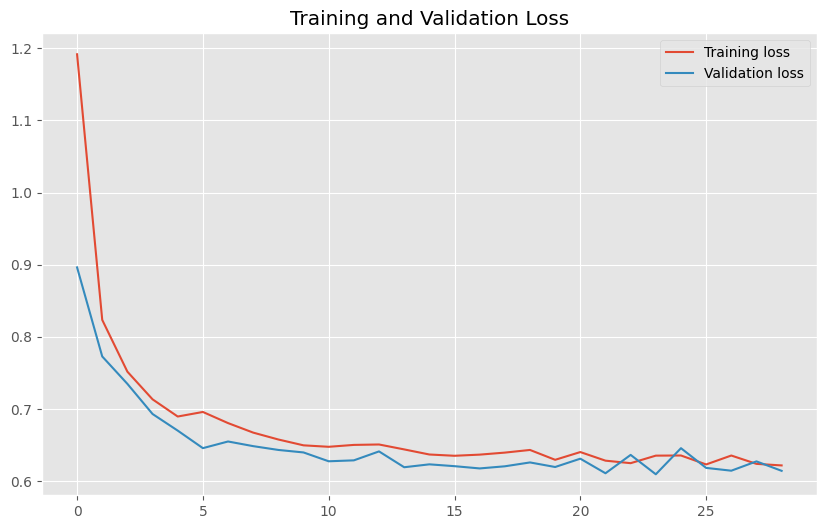

In [69]:
import matplotlib.pyplot as plt

# Retrieve the history of training and validation accuracy
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

# Retrieve the history of training and validation loss
loss = history.history['loss']
val_loss = history.history['val_loss']

# Determine the number of epochs
epochs = range(len(acc))

# Plot training and validation accuracy
plt.figure(figsize=(10, 6))
plt.plot(epochs, acc, label='Training accuracy')
plt.plot(epochs, val_acc, label='Validation accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

# Plot training and validation loss
plt.figure(figsize=(10, 6))
plt.plot(epochs, loss, label='Training loss')
plt.plot(epochs, val_loss, label='Validation loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.show()


In [20]:
if not os.path.isdir('tumorous_and_nontumorous'):
    base_dir = 'tumorous_and_nontumorous'
    os.mkdir(base_dir)

use a pretrained MOdel VGG19

In [74]:
from tensorflow.keras.applications import VGG19
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint



# Initialize the base VGG19 model
base_model = VGG19(weights='imagenet', include_top=False, input_shape=(150, 150, 3))

# Freeze the convolutional base to prevent weights from being updated during training
for layer in base_model.layers:
    layer.trainable = False

# Add custom layers on top of the VGG19 base
model = models.Sequential([
    base_model,
    layers.Flatten(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(1, activation='sigmoid')  # Sigmoid activation for binary classification
])

# Compile the model
model.compile(loss='binary_crossentropy',
              optimizer=optimizers.Adam(lr=1e-4),  # Lower learning rate to prevent overfitting
              metrics=['accuracy'])

# Data augmentation for the training data
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Note that validation data should not be augmented
validation_datagen = ImageDataGenerator(rescale=1./255)

# Train and validation generators
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(150, 150),
    batch_size=20,
    class_mode='binary'
)

validation_generator = validation_datagen.flow_from_directory(
    validation_dir,
    target_size=(150, 150),
    batch_size=20,
    class_mode='binary'
)

# Callbacks: EarlyStopping and ModelCheckpoint
callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, verbose=1),
    ModelCheckpoint(filepath='vgg19_best_model.h5', monitor='val_accuracy', save_best_only=True, verbose=1)
]
# Correct the optimizer parameter
optimizer = optimizers.Adam(learning_rate=1e-4)

# Define the number of steps per epoch and validation steps based on your data
steps_per_epoch = math.ceil(1558 / 20)  # Assuming batch_size is 20
validation_steps = math.ceil(195 / 20)  # Assuming batch_size is 20

# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=20,  # Number of epochs to train for
    validation_data=validation_generator,
    validation_steps=validation_steps,
    callbacks=callbacks,
    verbose=1
)

# Evaluate the model on the test data
test_generator = validation_datagen.flow_from_directory(
    test_dir,
    target_size=(150, 150),
    batch_size=20,
    class_mode='binary'
)

test_loss, test_acc = model.evaluate(test_generator, steps=math.ceil(test_generator.samples / 20))

# Print the test accuracy
print(f'Test accuracy: {test_acc:.2f}%')


Found 1558 images belonging to 2 classes.
Found 195 images belonging to 2 classes.
Epoch 1/20
78/78 [==============================] - ETA: 0s - loss: 0.7704 - accuracy: 0.6187
Epoch 1: val_accuracy improved from -inf to 0.78974, saving model to vgg19_best_model.h5
78/78 [==============================] - 12s 133ms/step - loss: 0.7704 - accuracy: 0.6187 - val_loss: 0.4852 - val_accuracy: 0.7897
Epoch 2/20
78/78 [==============================] - ETA: 0s - loss: 0.5474 - accuracy: 0.7246
Epoch 2: val_accuracy improved from 0.78974 to 0.83590, saving model to vgg19_best_model.h5
78/78 [==============================] - 10s 129ms/step - loss: 0.5474 - accuracy: 0.7246 - val_loss: 0.4075 - val_accuracy: 0.8359
Epoch 3/20
78/78 [==============================] - ETA: 0s - loss: 0.5073 - accuracy: 0.7490
Epoch 3: val_accuracy did not improve from 0.83590
78/78 [==============================] - 10s 125ms/step - loss: 0.5073 - accuracy: 0.7490 - val_loss: 0.4122 - val_accuracy: 0.7949
Epoch 4

plote the enhanced MOdel

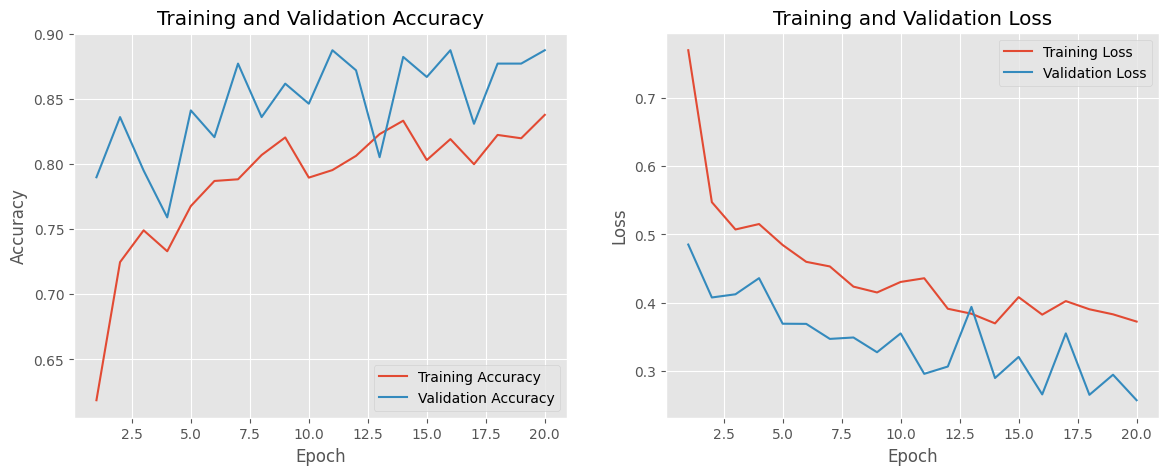

In [75]:
import matplotlib.pyplot as plt

# Replace these lists with the actual history data
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

# Set the range of epochs
epochs = range(1, len(acc) + 1)

# Plot training and validation accuracy
plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, acc, label='Training Accuracy')
plt.plot(epochs, val_acc, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot training and validation loss
plt.subplot(1, 2, 2)
plt.plot(epochs, loss, label='Training Loss')
plt.plot(epochs, val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()


Load Your Model and Define the Prediction Function

In [77]:
!pip install flask


In [ ]:
from flask import Flask, request, jsonify
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
import numpy as np
import os

app = Flask(__name__)

# Load the saved VGG19 model
model = load_model('vgg19_best_model.h5')

def allowed_file(filename):
    return '.' in filename and filename.rsplit('.', 1)[1].lower() in {'png', 'jpg', 'jpeg'}

def preprocess_image(image_path):
    img = image.load_img(image_path, target_size=(150, 150))
    img_array = image.img_to_array(img)
    img_array_expanded_dims = np.expand_dims(img_array, axis=0)
    return img_array_expanded_dims / 255.

def predict_mri(image_path):
    processed_image = preprocess_image(image_path)
    prediction = model.predict(processed_image)
    predicted_class = 'Yes' if prediction[0][0] > 0.5 else 'No'
    return predicted_class

@app.route('/predict', methods=['POST'])
def predict():
    if 'file' not in request.files:
        return 'No file part', 400

    file = request.files['file']
    if file.filename == '':
        return 'No selected file', 400

    if file and allowed_file(file.filename):
        # You might want to secure this path or handle the storage differently
        image_path = os.path.join('uploads', file.filename)
        file.save(image_path)
        result = predict_mri(image_path)
        return jsonify({'prediction': result})

    return 'Error processing the request', 500

if __name__ == '__main__':
    app.run(debug=True)



 * Serving Flask app '__main__'
 * Debug mode: on


INFO:werkzeug:WARNING: This is a development server. Do not use it in a production deployment. Use a production WSGI server instead.
 * Running on http://127.0.0.1:5000
INFO:werkzeug:Press CTRL+C to quit
INFO:werkzeug: * Restarting with stat
